In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import h2o
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import adjusted_rand_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from h2o.estimators.deeplearning import H2OAutoEncoderEstimator

In [2]:
data = pd.read_csv("heart.csv", sep=',')
data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,59,1,1,140,221,0,1,164,1,0.0,2,0,2,1
1021,60,1,0,125,258,0,0,141,1,2.8,1,1,3,0
1022,47,1,0,110,275,0,0,118,1,1.0,1,1,2,0
1023,50,0,0,110,254,0,0,159,0,0.0,2,0,2,1


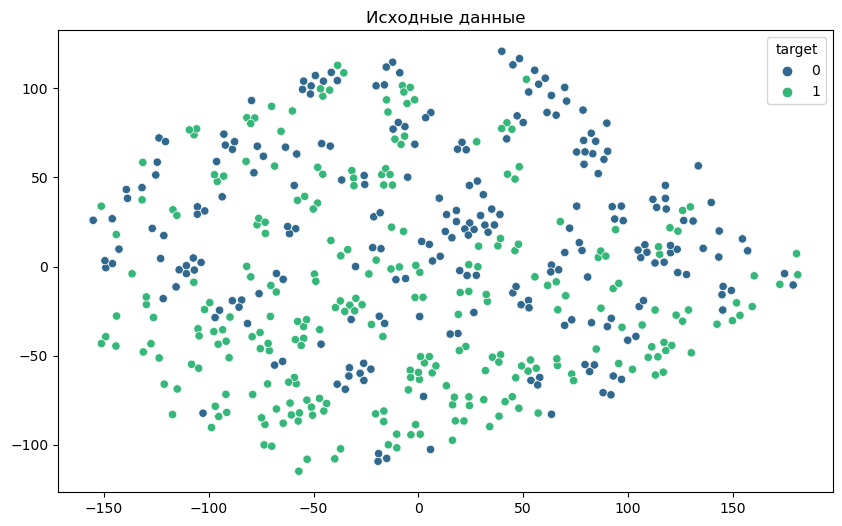

In [62]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

# Инициализация t-SNE
tsne = TSNE(n_components=2, random_state=7567)

plt.figure(figsize=(10, 6))
X_tsne = tsne.fit_transform(X)
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette='viridis', legend='full')
plt.title('Исходные данные')
plt.show()

# Разделим на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=7567, stratify=y)


Оптимальное значение k: 3
Минимальная ошибка на тестовых данных с k=3: 0.02


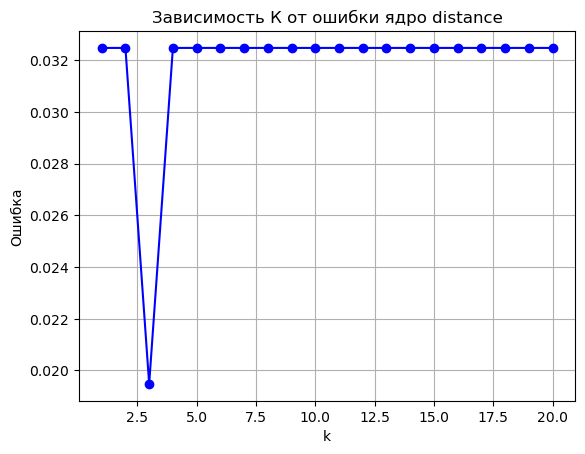

In [66]:
k_values = list(range(1, 21))
error_values = []

best_k = None
best_error = float('inf')

for k in k_values:
    knn_classifier = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn_classifier.fit(X_train, y_train)
    y_pred = knn_classifier.predict(X_test)
    error = 1 - accuracy_score(y_test, y_pred)
    
    if error < best_error:
        best_error = error
        best_k = k
    
    error_values.append(error)

print(f"Оптимальное значение k: {best_k}")
print(f"Минимальная ошибка на тестовых данных с k={best_k}: {best_error:.2f}")

plt.plot(k_values, error_values, marker='o', linestyle='-', color='b')
plt.title('Зависимость К от ошибки ядро distance')
plt.xlabel('k')
plt.ylabel('Ошибка')
plt.grid(True)
plt.show()

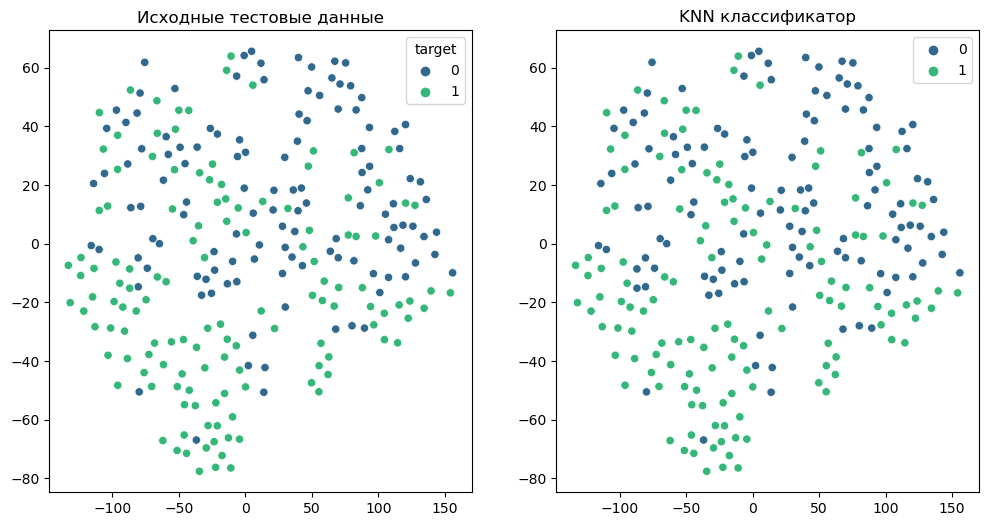

In [67]:
knn_classifier = KNeighborsClassifier(n_neighbors=3, weights='distance')
knn_classifier.fit(X_train, y_train)
y_pred = knn_classifier.predict(X_test)

# Применение t-SNE для визуализации данных
tsne = TSNE(n_components=2, random_state=7567)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
X_test_tsne = tsne.fit_transform(X_test)
sns.scatterplot(x=X_test_tsne[:, 0], y=X_test_tsne[:, 1], hue=y_test, palette='viridis', legend='full')
plt.title('Исходные тестовые данные')

plt.subplot(1, 2, 2)
X_test_tsne = tsne.fit_transform(X_test)
sns.scatterplot(x=X_test_tsne[:, 0], y=X_test_tsne[:, 1], hue=y_pred, palette='viridis', legend='full')
plt.title('KNN классификатор')
plt.show()

Оптимальное значение k: 1
Минимальная ошибка на тестовых данных с k=1: 0.03


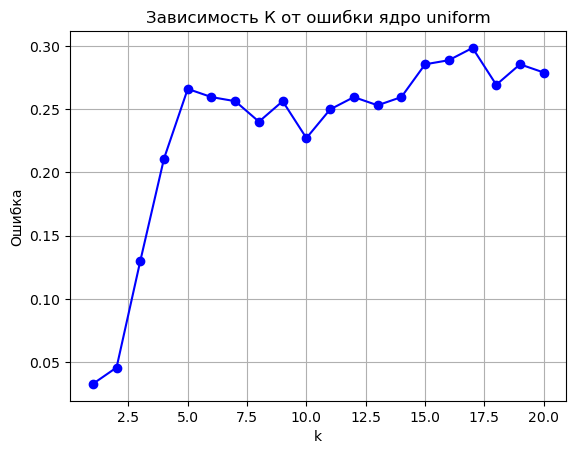

In [55]:
k_values = list(range(1, 21))
error_values = []

best_k = None
best_error = float('inf')

for k in k_values:
    knn_classifier = KNeighborsClassifier(n_neighbors=k, weights='uniform')
    knn_classifier.fit(X_train, y_train)
    y_pred = knn_classifier.predict(X_test)
    error = 1 - accuracy_score(y_test, y_pred)
    
    if error < best_error:
        best_error = error
        best_k = k
    
    error_values.append(error)

print(f"Оптимальное значение k: {best_k}")
print(f"Минимальная ошибка на тестовых данных с k={best_k}: {best_error:.2f}")


plt.plot(k_values, error_values, marker='o', linestyle='-', color='b')
plt.title('Зависимость К от ошибки ядро uniform')
plt.xlabel('k')
plt.ylabel('Ошибка')
plt.grid(True)
plt.show()

Лучшее значение n_estimators(количества деревьев): 5
Оценка ошибки для лучшего значения: 0.01


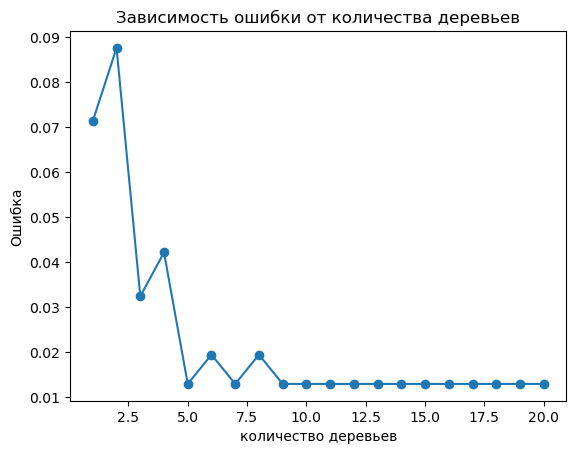

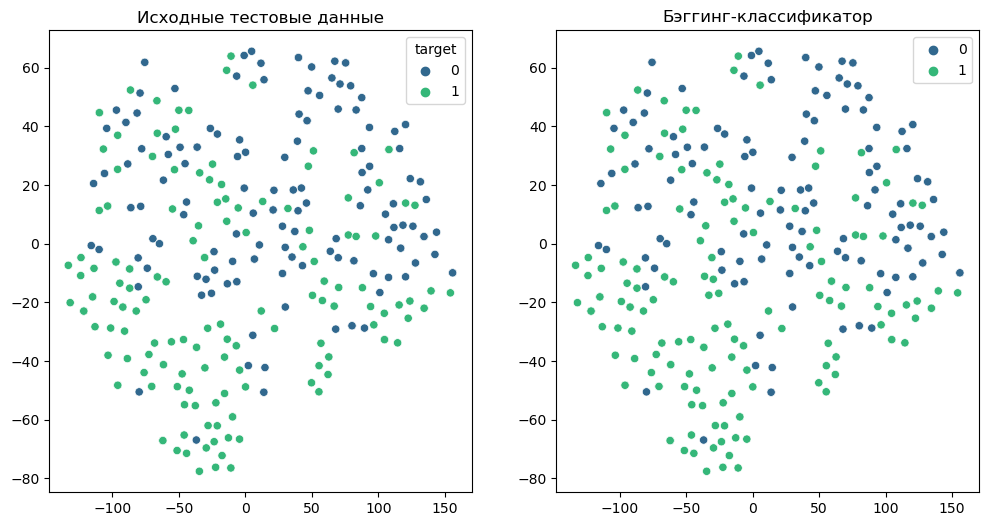

In [72]:
# Создание и обучение бэггинг-классификатора
n_estimators_range = range(1, 21)
errors = []

for n_estimators in n_estimators_range:
    bagging_classifier = BaggingClassifier(n_estimators=n_estimators, random_state=7567)
    bagging_classifier.fit(X_train, y_train)
    y_pred = bagging_classifier.predict(X_test)

    error = 1 - accuracy_score(y_test, y_pred)
    errors.append(error)
    
best_n_estimators = n_estimators_range[np.argmin(errors)]
best_error = min(errors)

print(f"Лучшее значение n_estimators(количества деревьев): {best_n_estimators}")
print(f"Оценка ошибки для лучшего значения: {best_error:.2f}")

plt.plot(n_estimators_range, errors, marker='o')
plt.title('Зависимость ошибки от количества деревьев')
plt.xlabel('количество деревьев')
plt.ylabel('Ошибка')
plt.show()

best_bagging_classifier = BaggingClassifier(n_estimators=best_n_estimators, random_state=7567)
best_bagging_classifier.fit(X_train, y_train)
y_pred_best = best_bagging_classifier.predict(X_test)

# Применение t-SNE для визуализации данных
tsne = TSNE(n_components=2, random_state=7567)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
X_test_tsne = tsne.fit_transform(X_test) 
sns.scatterplot(x=X_test_tsne[:, 0], y=X_test_tsne[:, 1], hue=y_test, palette='viridis', legend='full')
plt.title('Исходные тестовые данные')

plt.subplot(1, 2, 2)
X_test_tsne_best = tsne.fit_transform(X_test)
sns.scatterplot(x=X_test_tsne_best[:, 0], y=X_test_tsne_best[:, 1], hue=y_pred_best, palette='viridis', legend='full')
plt.title('Бэггинг-классификатор')
plt.show()

Лучшее значение n_estimators(количества деревьев): 252
Оценка ошибки для лучшего значения: 0.01


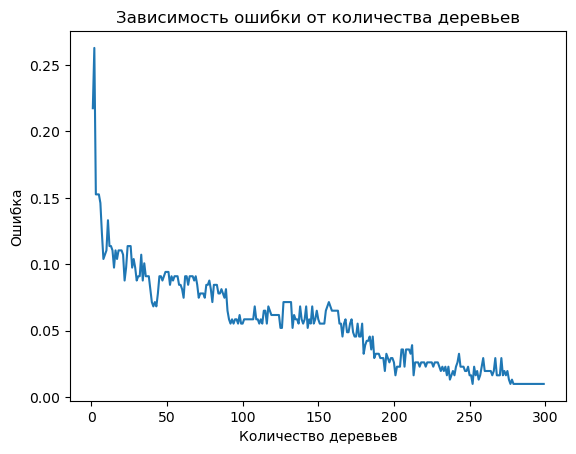

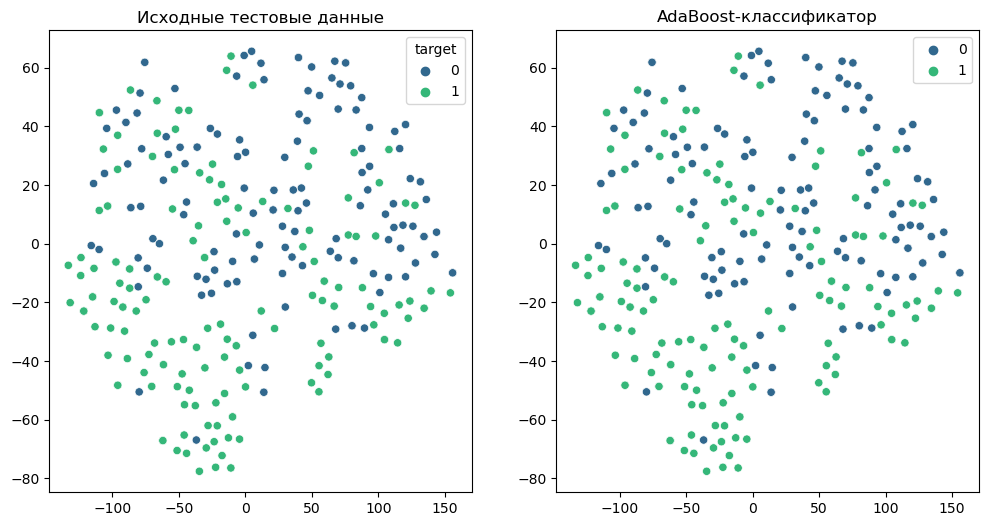

In [79]:
print(f"Лучшее значение n_estimators(количества деревьев): {best_n_estimators}")
print(f"Оценка ошибки для лучшего значения: {best_error:.2f}")

plt.plot(n_estimators_range, errors)
plt.title('Зависимость ошибки от количества деревьев')
plt.xlabel('Количество деревьев')
plt.ylabel('Ошибка')
plt.show()

# Создание и обучение AdaBoost-классификатора с лучшим значением n_estimators
best_adaboost_classifier = AdaBoostClassifier(n_estimators=best_n_estimators, random_state=7567)
best_adaboost_classifier.fit(X_train, y_train)
y_pred_best = best_adaboost_classifier.predict(X_test)

# Применение t-SNE для визуализации данных
tsne = TSNE(n_components=2, random_state=7567)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
X_test_tsne = tsne.fit_transform(X_test)  # Применение t-SNE к тестовым данным
sns.scatterplot(x=X_test_tsne[:, 0], y=X_test_tsne[:, 1], hue=y_test, palette='viridis', legend='full')
plt.title('Исходные тестовые данные')

plt.subplot(1, 2, 2)
X_test_tsne_best = tsne.fit_transform(X_test)
sns.scatterplot(x=X_test_tsne_best[:, 0], y=X_test_tsne_best[:, 1], hue=y_pred_best, palette='viridis', legend='full')
plt.title('AdaBoost-классификатор')
plt.show()

In [80]:
# Кластеризация данных методом k-средних
kmeans = KMeans(n_clusters=2)
predicted_clusters = kmeans.fit_predict(X)
errors = (predicted_clusters != y).sum() / len(y)
print(f'Ошибка: {errors:.2f}')

C:\Users\alika2\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\alika2\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


Ошибка: 0.43


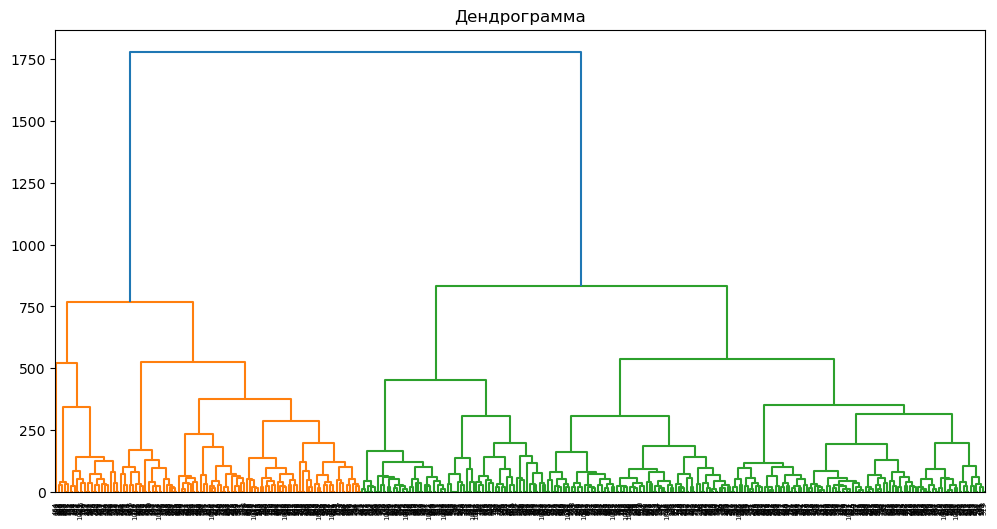

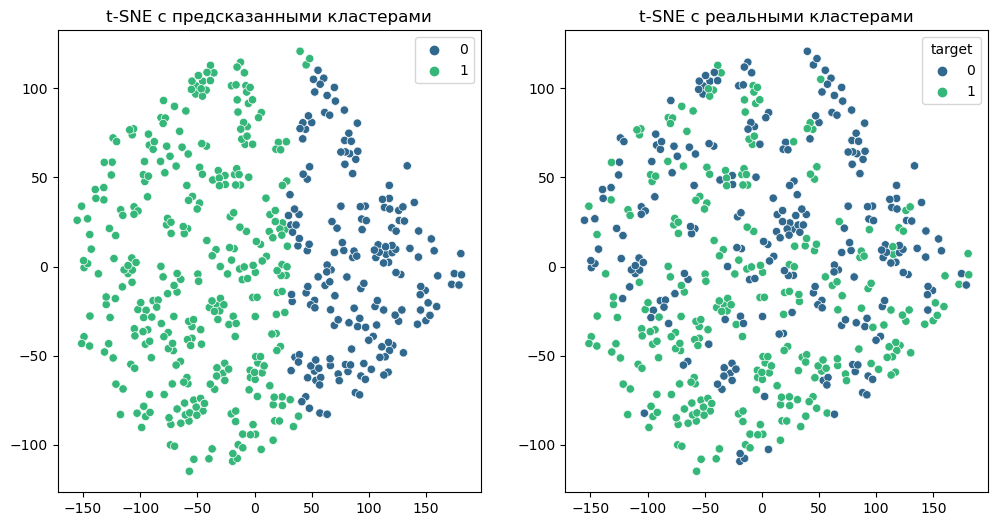

In [81]:
# Построение дендрограммы
linkage_matrix = linkage(X, method='ward')
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix)
plt.title('Дендрограмма')
plt.show()

# Применение t-SNE для визуализации данных
tsne = TSNE(n_components=2, random_state=7567)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
X_tsne_predicted = tsne.fit_transform(X)
sns.scatterplot(x=X_tsne_predicted[:, 0], y=X_tsne_predicted[:, 1], hue=predicted_clusters, palette='viridis', legend='full')
plt.title('t-SNE с предсказанными кластерами')

plt.subplot(1, 2, 2)
sns.scatterplot(x=X_tsne_predicted[:, 0], y=X_tsne_predicted[:, 1], hue=y, palette='viridis', legend='full')
plt.title('t-SNE с реальными кластерами')
plt.show()

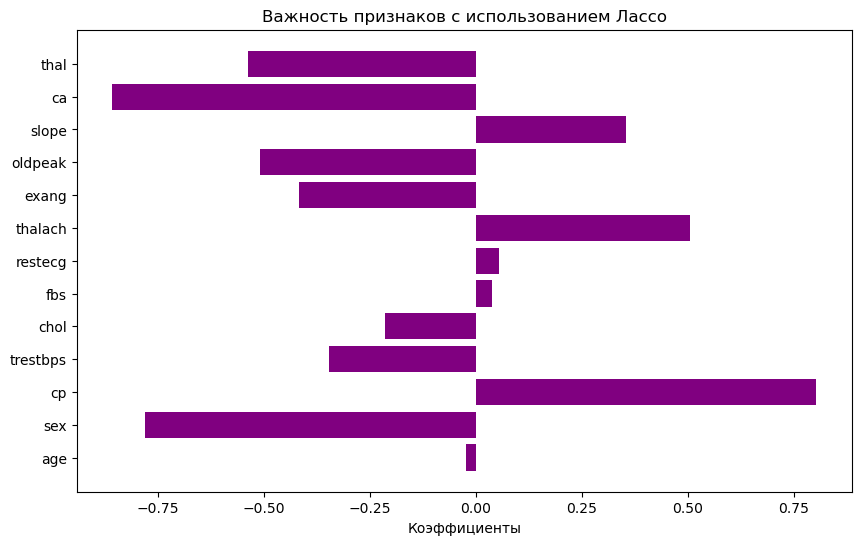

In [83]:
# Масштабирование признаков 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Модель
lasso_model = LogisticRegression(penalty='l1', solver='liblinear')
lasso_model.fit(X_train_scaled, y_train)

# Коэффициенты
feature_names = X.columns
coefficients = lasso_model.coef_[0]

# Построение графика важности признаков
plt.figure(figsize=(10, 6))
plt.barh(feature_names, coefficients, color='purple')
plt.xlabel('Коэффициенты')
plt.title('Важность признаков с использованием Лассо')
plt.show()

In [15]:
# pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,7 hours 27 mins
H2O_cluster_timezone:,Europe/Moscow
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,1 month and 1 day
H2O_cluster_name:,H2O_from_python_alika2_l8qhrx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.820 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


C:\Users\alika2\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


C:\Users\alika2\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


ошибка: 0.02922077922077926


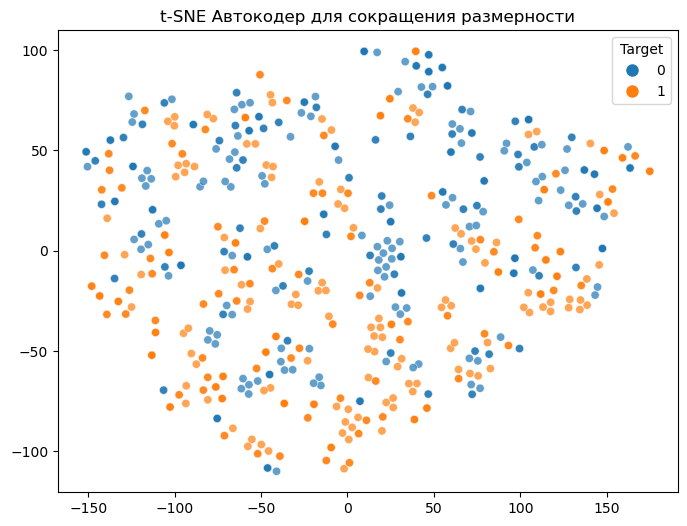

In [89]:
data = pd.read_csv("heart.csv", sep=',')
X = data.drop('target', axis=1)
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=7567, stratify=y)

h2o.init()
h2o_train = h2o.H2OFrame(pd.concat([X_train, y_train.to_frame()], axis=1))

autoencoder = H2OAutoEncoderEstimator(activation="Tanh",autoencoder=True)
autoencoder.train(x=list(range(X_train.shape[1])), training_frame=h2o_train)

encoded_train = autoencoder.predict(h2o_train)
encoded_train = encoded_train.as_data_frame().values

adaboost_classifier = AdaBoostClassifier()
adaboost_classifier.fit(encoded_train, y_train)

encoded_test = autoencoder.predict(h2o.H2OFrame(X_test)).as_data_frame().values
accuracy = adaboost_classifier.score(encoded_test, y_test)
print("ошибка:", 1-accuracy)

tsne = TSNE(n_components=2, random_state=7567)
encoded_tsne = tsne.fit_transform(encoded_train)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=encoded_tsne[:, 0], y=encoded_tsne[:, 1], hue=y_train, palette={0: '#1f77b4', 1: '#ff7f0e'}, alpha=0.7)
plt.title('t-SNE Автокодер для сокращения размерности')
plt.legend(title='Target', loc='best', labels=['0', '1'], 
           handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in ['#1f77b4', '#ff7f0e']])
plt.show()


Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,7 hours 29 mins
H2O_cluster_timezone:,Europe/Moscow
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,1 month and 1 day
H2O_cluster_name:,H2O_from_python_alika2_l8qhrx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.819 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


C:\Users\alika2\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


C:\Users\alika2\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Ошибка: 0.058441558441558406


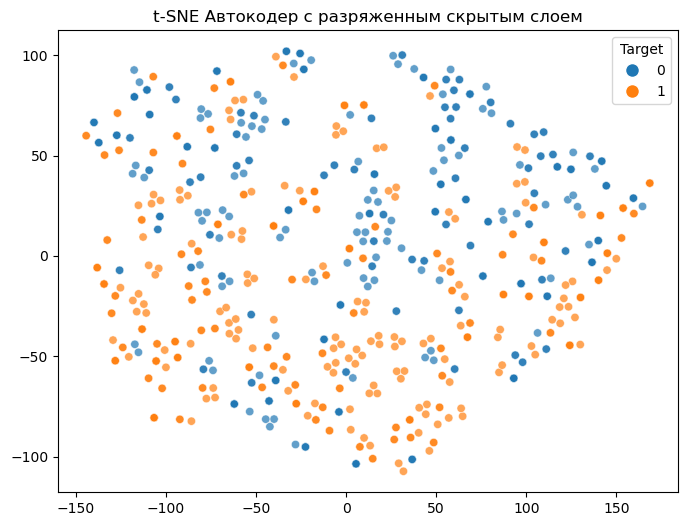

In [90]:
data = pd.read_csv("heart.csv", sep=',')
X = data.drop('target', axis=1)
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=7567, stratify=y)

h2o.init()
h2o_train = h2o.H2OFrame(pd.concat([X_train, y_train.to_frame()], axis=1))

# Инициализация автокодера с разреженным скрытым слоем
autoencoder = H2OAutoEncoderEstimator(activation="Tanh", autoencoder=True, l1=1e-4)  # Регуляризация L1 для разреженности
autoencoder.train(x=list(range(X_train.shape[1])), training_frame=h2o_train)

encoded_train = autoencoder.predict(h2o_train)
encoded_train = encoded_train.as_data_frame().values

adaboost_classifier = AdaBoostClassifier()
adaboost_classifier.fit(encoded_train, y_train)

encoded_test = autoencoder.predict(h2o.H2OFrame(X_test)).as_data_frame().values
accuracy = adaboost_classifier.score(encoded_test, y_test)
print("Ошибка:", 1-accuracy)

# Визуализация новых обучающих данных при помощи t-SNE
tsne = TSNE(n_components=2, random_state=7567)
encoded_tsne = tsne.fit_transform(encoded_train)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=encoded_tsne[:, 0], y=encoded_tsne[:, 1], hue=y_train, palette={0: '#1f77b4', 1: '#ff7f0e'}, alpha=0.7)
plt.title('t-SNE Автокодер с разряженным скрытым слоем')
plt.legend(title='Target', loc='best', labels=['0', '1'], 
           handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in ['#1f77b4', '#ff7f0e']])
plt.show()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,7 hours 31 mins
H2O_cluster_timezone:,Europe/Moscow
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,1 month and 1 day
H2O_cluster_name:,H2O_from_python_alika2_l8qhrx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.818 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%
deepfeatures progress: |█████████████████████████████████████████████████████████| (done) 100%


C:\Users\alika2\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


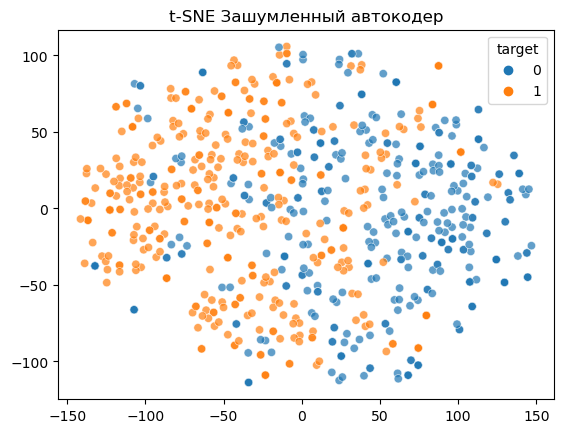

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
deepfeatures progress: |█████████████████████████████████████████████████████████| (done) 100%


C:\Users\alika2\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Ошибка: 0.051948051948051965


In [91]:
data = pd.read_csv("heart.csv", sep=',')

# Часть данных которая будет зашумлена
subset_size = 100
subset_indices = np.random.choice(data.shape[0], size=subset_size, replace=False)

X = data.drop('target', axis=1)
y = data['target']

X_subset = X.iloc[subset_indices]
y_subset = y.iloc[subset_indices]

noise_subset = np.random.normal(0, 1, size=(subset_size, X.shape[1]))
X_subset_with_noise = X_subset + noise_subset

X_with_noise = X.copy()
X_with_noise.iloc[subset_indices] = X_subset_with_noise

X_train, X_test, y_train, y_test = train_test_split(X_with_noise, y, train_size=0.7, random_state=7567, stratify=y)

h2o.init()
h2o_train = h2o.H2OFrame(pd.concat([X_train, y_train.to_frame()], axis=1))

autoencoder = H2OAutoEncoderEstimator(activation="Tanh",autoencoder=True)
autoencoder.train(x=list(range(X_train.shape[1])), training_frame=h2o_train)

sparse_layer_train = autoencoder.deepfeatures(h2o_train, layer=1)
sparse_layer_train = sparse_layer_train.as_data_frame().values

tsne = TSNE(n_components=2, random_state=7567)
sparse_tsne = tsne.fit_transform(sparse_layer_train)

sns.scatterplot(x=sparse_tsne[:, 0], y=sparse_tsne[:, 1], hue=y_train, alpha=0.7)
plt.title('t-SNE Зашумленный автокодер')
plt.show()

adaboost_classifier = AdaBoostClassifier()
adaboost_classifier.fit(sparse_layer_train, y_train)

sparse_layer_test = autoencoder.deepfeatures(h2o.H2OFrame(X_test), layer=1)
sparse_layer_test = sparse_layer_test.as_data_frame().values
accuracy = adaboost_classifier.score(sparse_layer_test, y_test)
print("Ошибка:", 1-accuracy)
